In [1]:
import os
import glob
import time
import wandb
import torch as T
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from models.models import RNN_head
from utilities.util import TrTstSplit, GetInputOutputSplit
from utilities.MocapDataset import MocapDataset_head

# Initializing data Loader

In [2]:
base_dir = '../../IEMOCAP_full_release/'
os.chdir(base_dir)
dirs = glob.glob('*.csv')
train, test = TrTstSplit(dirs)
head, aud, _, _ = GetInputOutputSplit(train)
dataset = MocapDataset_head(aud, head)
dataset_size = len(aud)
dataloader = T.utils.data.DataLoader(dataset, batch_size=1, num_workers=2)
wandb.init(
    # set the wandb project where this run will be logged
    project="head_nods",
    
    # track hyperparameters and run metadata
    config={
    "learning_rate": 0.001,
    "architecture": "LSTM",
    "dataset": "IEMOCAP",
    "epochs": 1000,
    }
)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


['Session5.csv', 'Session1.csv', 'Session4.csv', 'Session3.csv']


wandb: Currently logged in as: ghosh-bishal (bigzen0). Use `wandb login --relogin` to force relogin


# Training

In [3]:
min_loss=100
device = T.device("cuda:0" if T.cuda.is_available() else "cpu")
rnn = RNN_head(28,256,1,3).to(device)
rnn.load_state_dict(T.load('../MSc_Thesis/MSc_Thesis/models/head_bestmodel.pth')['model_state_dict'])
criterion = T.nn.MSELoss()
optimizer = T.optim.Adam(rnn.parameters(), lr=0.001)
scheduler = T.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=10, threshold=0.01, threshold_mode='rel', verbose=True)
for epoch in range(1000):
    loop = tqdm(dataloader)
    rnn.train()
    running_loss = 0.0
    running_corrects = 0.0
    for audio, pose, _ in loop:
        audio = audio.to(device)
        pose = pose.to(device)
        optimizer.zero_grad()
        with T.set_grad_enabled(True):
          outputs = rnn(T.squeeze(audio))
          loss = criterion(outputs, T.squeeze(pose))
          loss.backward()
          optimizer.step()

        # statistics
        running_loss += loss.item()
        loop.set_description(f"Epoch [{epoch}]")
        loop.set_postfix(loss=loss.item())
    epoch_loss = running_loss / dataset_size
    scheduler.step(epoch_loss)
    wandb.log({ "loss": epoch_loss})
    #print('Epoch: {:.4f} Loss: {:.4f}'.format(
    #            epoch, epoch_loss ))
    if min_loss>epoch_loss:
      min_loss=epoch_loss
      T.save({'epoch': epoch,
              'model_state_dict': rnn.state_dict(),
              'optimizer_state_dict': optimizer.state_dict(),
              'loss': loss}, '../MSc_Thesis/MSc_Thesis/models/head_bestmodel.pth'.format(epoch))


/home/bishal/anaconda3/envs/backchannel/lib/python3.10/site-packages/torch/nn/modules/rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
Epoch [284]: 100%|██████████| 3849/3849 [00:22<00:00, 169.04it/s, loss=19.1]


Epoch 00285: reducing learning rate of group 0 to 1.0000e-04.


Epoch [954]: 100%|██████████| 3849/3849 [00:24<00:00, 159.62it/s, loss=5.67]


Epoch 00955: reducing learning rate of group 0 to 1.0000e-05.


Epoch [965]: 100%|██████████| 3849/3849 [00:23<00:00, 165.59it/s, loss=6.47]


Epoch 00966: reducing learning rate of group 0 to 1.0000e-06.


Epoch [976]: 100%|██████████| 3849/3849 [00:23<00:00, 165.89it/s, loss=6.49]


Epoch 00977: reducing learning rate of group 0 to 1.0000e-07.


Epoch [987]: 100%|██████████| 3849/3849 [00:23<00:00, 165.36it/s, loss=6.49]


Epoch 00988: reducing learning rate of group 0 to 1.0000e-08.


Epoch [999]: 100%|██████████| 3849/3849 [00:23<00:00, 165.87it/s, loss=6.49]


# Testing and Visualisation

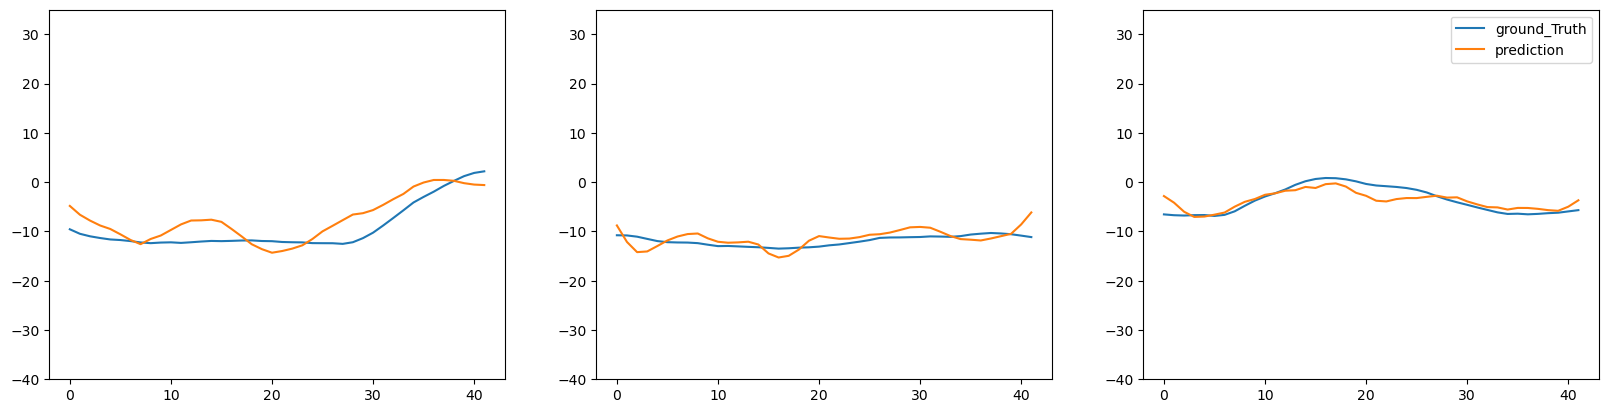

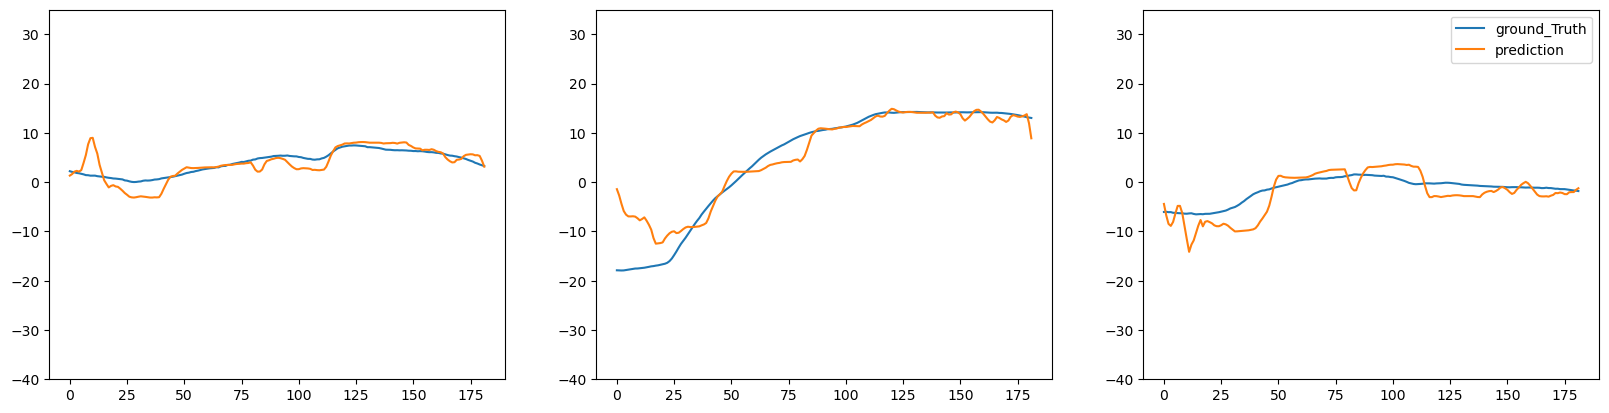

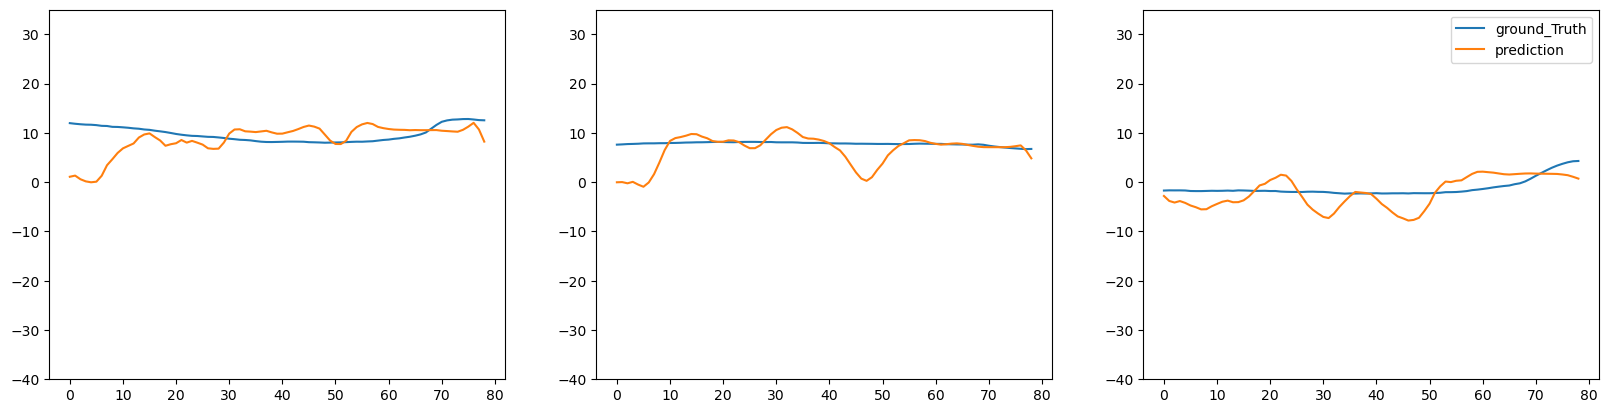

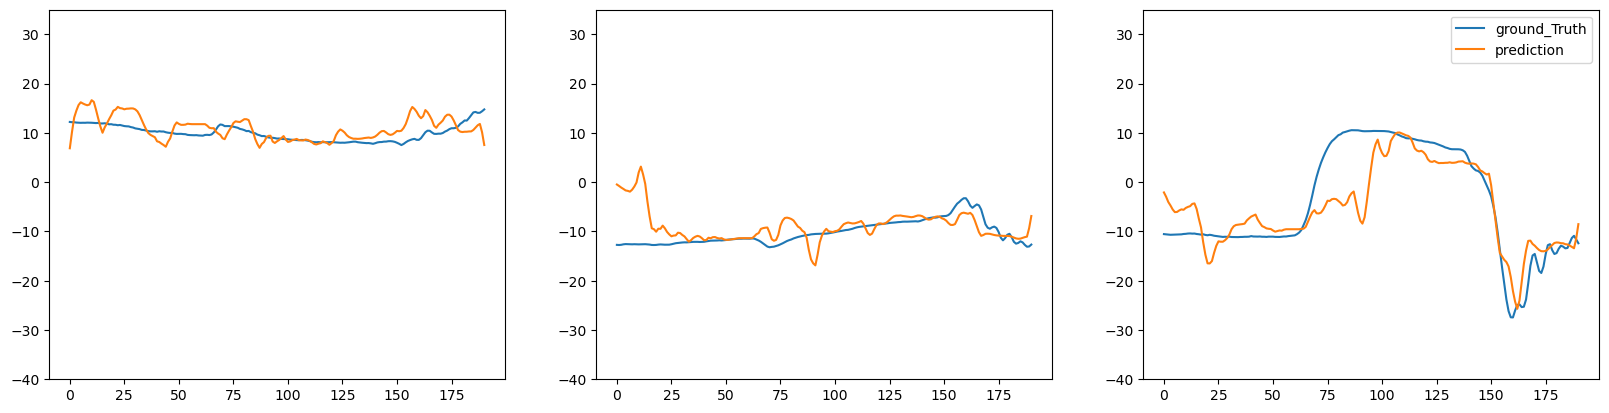

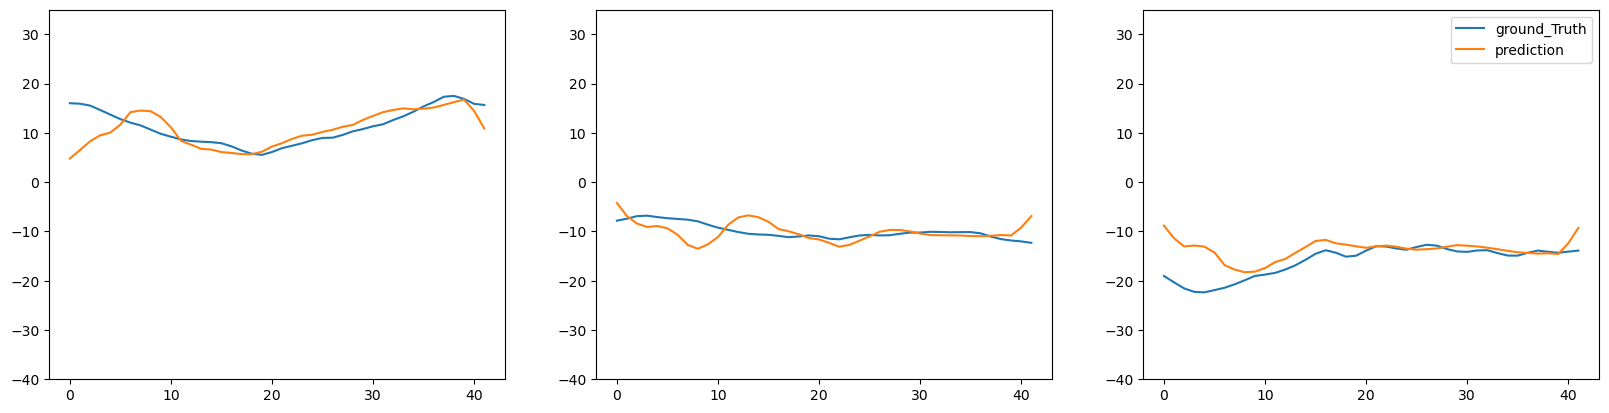

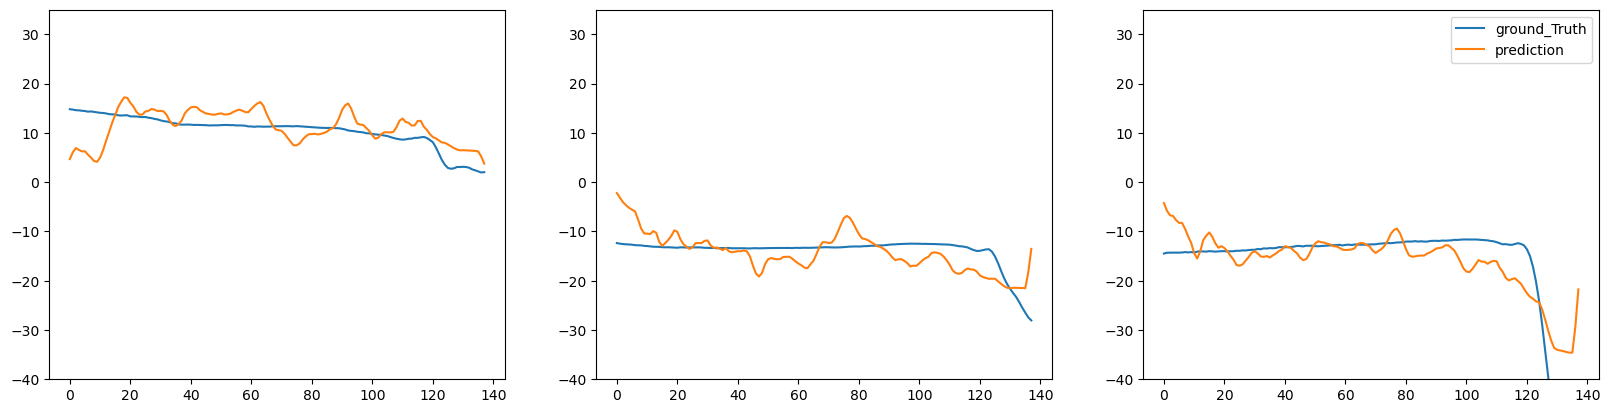

17.93768813797597 time per frame 1.4841072112634346e-05 20.352318402217783 17.308379400553175


In [4]:
criterion = T.nn.MSELoss()
device = T.device("cuda:0" if T.cuda.is_available() else "cpu")
rnn = RNN_head(28,256,1,3).to(device)
rnn.load_state_dict(T.load('../MSc_Thesis/MSc_Thesis/models/head_bestmodel.pth')['model_state_dict'])
rnn.eval()
out, inp,_,_ = GetInputOutputSplit(test)
dataset = MocapDataset_head(inp, out)
dataset_size = len(inp)
dataloader = T.utils.data.DataLoader(dataset, batch_size=1, num_workers=2)
running_loss = 0.0
m_l = 0.0
m_c = 0
f_l = 0.0
f_c = 0
rnn.to(device)
i=0
tick = 0

for audio, pose, name in dataloader:
    audio = audio.to(device)
    pose = pose.to(device)
    pose = np.squeeze(pose)
    t_strt = time.time()
    outputs = rnn(T.squeeze(audio))
    x_values = np.linspace(-1, 1, 5)
    w_m = T.Tensor(np.exp(-np.power(x_values, 2.) / (2 * np.power(1, 2.))))
    weights = T.unsqueeze(w_m/sum(w_m),0).expand(3,1,-1)
    out=T.nn.functional.conv1d(T.unsqueeze(T.transpose(outputs,0,1),0),weights.cuda(),groups=3,padding='same')
    outputs = T.transpose(T.squeeze(out),0,1)
    t_end = time.time()
    tick = tick+((t_end-t_strt)/outputs.shape[0])
    loss = criterion(outputs, T.squeeze(pose))
    #visualisation
    parts = name[0].split('_')
    # statistics
    if parts[3][0]=='M':
      m_l += loss.item()
      m_c += 1
    else:
      f_l += loss.item()
      f_c += 1
    running_loss += loss.item()
    if i<=5:
        outs = outputs.to('cpu').detach().numpy()
        ax,fig = plt.subplots(1,3)
        ax.set_figwidth(20)
        fig[0].set_ylim([-40,35])
        fig[1].set_ylim([-40,35])
        fig[2].set_ylim([-40,35])
        pose = pose.to('cpu').detach().numpy()
        fig[0].plot(pose[:,0], label='ground_Truth')
        fig[0].plot(outs[:,0], label='prediction')
        fig[1].plot(pose[:,1], label='ground_Truth')
        fig[1].plot(outs[:,1], label='prediction')
        fig[2].plot(pose[:,2], label='ground_Truth')
        fig[2].plot(outs[:,2], label='prediction')
        plt.legend()
        plt.show()
        i+=1

test_loss = running_loss / dataset_size
avg_time = tick / dataset_size
male = m_l/m_c
fem = f_l/f_c
print(test_loss, f'time per frame {avg_time}', male, fem)